# Latent Factor DBCM Analysis

This example highlights several advanced modeling strategies. 


**Dynamic Binary Cascade Model**

The first is a Dynamic Binary Cascade Model (DBCM), which is the combination a Dynamic Count Mixture Model (DCMM) and a binary cascade (Berry et. al. 2020). When modeling sales in a retail setting, the DCMM (Berry and West, 2019) is used to model the number of transactions involving an item, and the binary cascade models the quantity purchased by each customer. The DCMM models the transactions as a mixture of a Bernoulli and Poisson DGLM:

\begin{equation} \label{eqn-dcmm}
z_t \sim Ber(\pi_t) \text{ and } y_t \mid z_t =
\begin{cases}
0, & \text{if } z_t = 0,\\
1 + x_t, \quad x_t \sim Po(\mu_t), & \text{if }z_t = 1
\end{cases}
\end{equation}

where $\pi_t$ and $\mu_t$ vary according to the dynamics of independent Bernoulli and Poisson DGLMs respectively:

\begin{equation*}
\text{logit}(\pi_t) = \mathbf{F}_{ber, t}^{'}\boldsymbol{\theta}_{ber, t} \qquad \text{and} \qquad \text{log}(\mu_t) = \mathbf{F}_{Po, t}^{'} \boldsymbol{\theta}_{Po, t}
\end{equation*}

A DCMM is useful to capture a higher prevalence of $0$ outcomes than in a standard Poisson DGLM.

Transactions are related to sales by modeling the number of units bought in each transaction. Recognizing that sales outliers often occur due to shoppers buying many units of an item, the probability of each quantity is modeled with a binary cascade. Let $n_{r,t}$ be the number of transactions with more than $r$ units. Then $n_{r,t} | n_{r-1, t} \sim Bin(n_{r-1,t}, \pi_{r,t})$ is defined by a binomial DGLM. This cascade of binomial DGLMs represents the sequence of conditional probabilities for purchasing $n$ units or greater, given that the shopper has bought $n-1$. This implies the following expression for sales $y_t$:

\begin{equation}\label{eqn-dbcm}
y_t =
\begin{cases}
0, & \text{if } z_t = 0,\\
\sum_{r=1:d} r(n_{r-1, t} - n_{r,t}) + e_t, & \text{if }z_t = 1,
\end{cases}
\end{equation}
where $d$ is the predefined length of the cascade and $e_t$ represents excess units greater than $d$. The cascade enables modeling of very small probabilities, in the rare cases when shoppers purchase large quantities of an item on a single grocery store trip.

**Latent Factors**

The second strategy in this example is the use of *latent factors* for multiscale modeling. This example features simulated data from a retail sales setting. There is data for an item, and also for total sales at the store. The total sales are smoother and more predictable than the item level sales. A model is fit to the total sales which includes a day-of-week seasonal effect. This seasonal effect is extracted from the model on total sales, and used as a predictor in the item level model.

Modeling effects at different levels of a hierarchy - aka multiscale modeling - can improve forecast accuracy, because the sales of an individual can be very noisy, making it difficult to learn accurate patterns.

**Copula Forecasting**

In this example we are focusing on forecasting retail sales *1* through *14* days into the future. To do this, we will simulate from the joint forecast distribution *1:14* days into the future. This is accomplished in an efficient manner through the use of a Copula, which accounts for dependence in the forecasts across days into the future.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pybats.analysis import analysis, analysis_dbcm
from pybats.latent_factor import seas_weekly_lf
from pybats.shared import load_dbcm_latent_factor_example
from pybats.plot import plot_data_forecast
from pybats.point_forecast import median
from pybats.loss_functions import MAD

We start by loading the simulated retail sales data.

The dataframe 'totaldata' has the total daily sales in a store, along with a predictor, which represents a measure of average price.

The dataframe 'data' is the sales of a single item, and has two predictors. 'X_transaction' is a measure of price, and will be used in as a predictor in the DCMM. 'X_cascade' is a binary indicator of whether the item is being promoted within the store, and is used as a predictor in the binary cascade within the DBCM.

In [3]:
data = load_dbcm_latent_factor_example()
totaldata, data = data.values()
totaldata['Y'] = np.log(totaldata['Y'] + 1)

In [4]:
totaldata.head()

,Y,X
2014-06-01,5.746203,0.793644
2014-06-02,5.375278,-0.762627
2014-06-03,5.375278,-0.752116
2014-06-04,5.613128,-0.791505
2014-06-05,5.429346,-0.496851


In [5]:
data.head()

,Sales,Y_transaction,X_transaction,mt1,mt2,mt3,mt4,X_cascade,excess
2014-06-01,7.0,6.0,0.376729,1.0,0.0,0.0,0.0,0,[]
2014-06-02,3.0,3.0,1.797680,0.0,0.0,0.0,0.0,1,[]
2014-06-03,9.0,7.0,-1.687661,2.0,0.0,0.0,0.0,1,[]
2014-06-04,11.0,10.0,-0.188624,1.0,0.0,0.0,0.0,0,[]
2014-06-05,5.0,4.0,0.684483,1.0,0.0,0.0,0.0,1,[]


Here we define hyper parameters for the analysis:
-  *rho* is a discount factor which calibrates the forecast distribution. A value of *rho* less than $1$ increases the forecast variance. 

- *k* is the number of days ahead to forecast.

- *nsamps* is the number of forecast samples to draw.

- *prior_length* is the number of days of data to use when defining the priors for model coefficients.

In [6]:
#Define hyper parameters
rho = .2  # rho must be greater than 0, and is typically < 1. A smaller rho widens the forecast distribution.
k = 14 # Number of days ahead that we will forecast
nsamps = 200
prior_length = 21

Next, we define the window of time that we want to forecast over. For each day within this time period, the model will sample from the path (joint) forecast distribution *1:k* days into the future.

In [7]:
# Define the forecast range
T = len(totaldata)
forecast_end_date = totaldata.index[-k]
forecast_start_date = forecast_end_date - pd.DateOffset(days=365)

The first analysis is run on the 'totaldata', which is used to learn a latent factor. In this case, we fit a normal DLM to the log of total sales in order to learn the weekly season effect, which is stored in the latent factor.

In [8]:
# Get multiscale signal (a latent factor) from higher level log-normal model
latent_factor = analysis(totaldata['Y'].values, totaldata['X'].values, k,
                         forecast_start_date, forecast_end_date, dates=totaldata.index,
                         seasPeriods=[7], seasHarmComponents=[[1,2,3]],
                         family="normal", ret=['new_latent_factors'], new_latent_factors= [seas_weekly_lf.copy()],
                         prior_length=prior_length)

beginning forecasting


The second analysis is performed on 'data', which is the simulated sales of a single item. The latent factor is used to inform on the sales of this item. On each day, a copula is used to draw joint forecast samples from *1:k* days ahead.

In [9]:
# Update and forecast the model
mod, forecast_samples = analysis_dbcm(data['Y_transaction'].values.reshape(-1), data['X_transaction'].values.reshape(-1,1), 
                                 data[['mt1', 'mt2', 'mt3', 'mt4']].values, data['X_cascade'].values.reshape(-1,1),
                                 data['excess'].values,
                                 forecast_start=forecast_start_date, forecast_end=forecast_end_date,
                                 prior_length=prior_length, k=k, 
                                 nsamps=nsamps, rho=rho,
                                 latent_factor=latent_factor, dates = data.index,
                                 delregn_pois=.98)

beginning forecasting


Finally, we can examine the results, first by plotting both the *1-* and *14-* step ahead forecasts:

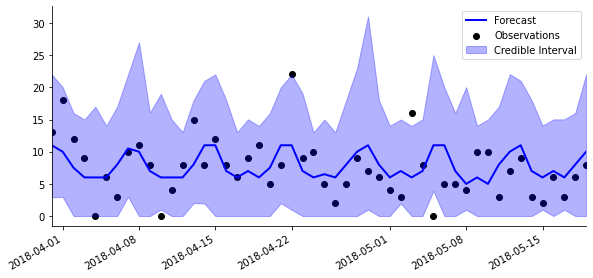

In [10]:
forecast = median(forecast_samples)

horizon = 1
plot_length = 50
fig, ax = plt.subplots(figsize=(8,4))
start_date = forecast_end_date + pd.DateOffset(horizon - plot_length)
end_date = forecast_end_date + pd.DateOffset(horizon - 1)
ax = plot_data_forecast(fig, ax, data.loc[start_date:end_date].Sales,
                        forecast[-plot_length:,horizon - 1],
                        forecast_samples[:,-plot_length:,horizon - 1],
                        data.loc[start_date:end_date].index,
                        linewidth = 2)

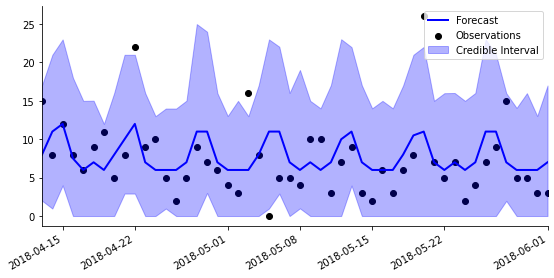

In [11]:
horizon = 14
plot_length = 50
fig, ax = plt.subplots(figsize=(8,4))
start_date = forecast_end_date + pd.DateOffset(horizon - plot_length)
end_date = forecast_end_date + pd.DateOffset(horizon - 1)
ax = plot_data_forecast(fig, ax, data.loc[start_date:end_date].Sales,
                        forecast[-plot_length:,horizon - 1],
                        forecast_samples[:,-plot_length:,horizon - 1],
                        data.loc[start_date:end_date].index,
                        linewidth = 2)

As well as looking at the mean absolute deviation (MAD) between the forecast median and the observations over the forecast horizons. Interestingly, there is only a small increase in the MAD for longer forecast horizons.

In [12]:
# Mean absolute deviation at increasing forecast horizons
horizons = list(range(1, k+1))
list(map(lambda k: MAD(data.loc[forecast_start_date + pd.DateOffset(k-1):forecast_end_date + pd.DateOffset(k-1)].Sales,
                      forecast[:,k-1]),
         horizons))

[3.07103825136612,
 3.0382513661202184,
 3.080601092896175,
 3.0628415300546448,
 3.1079234972677594,
 3.0942622950819674,
 3.0846994535519126,
 3.0860655737704916,
 3.08879781420765,
 3.1434426229508197,
 3.1420765027322406,
 3.129781420765027,
 3.080601092896175,
 3.069672131147541]